In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

from lightgbm import LGBMRegressor
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
train.head()


,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [3]:
# min and max date
print("train min date:", train['date'].min())
print("train max date:", train['date'].max())
print("test min date:", test['date'].min())
print("test max date:", test['date'].max())

train min date: 2017-01-01 00:00:00
train max date: 2020-12-31 00:00:00
test min date: 2021-01-01 00:00:00
test max date: 2021-12-31 00:00:00


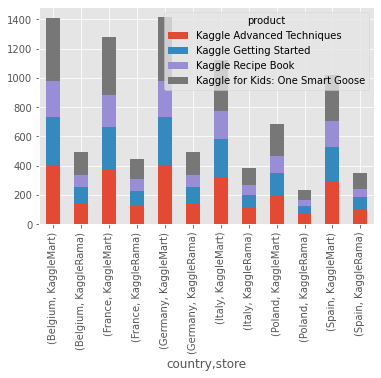

In [4]:
# sales 
train.groupby(['country','store','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=True)
plt.show()

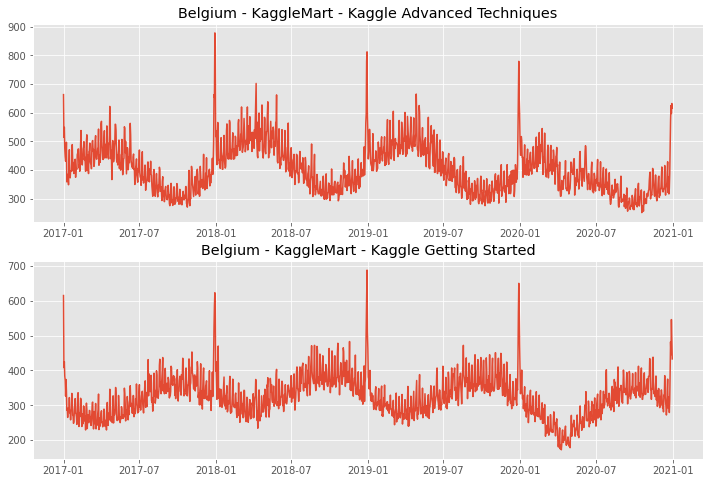

In [5]:
tmp = train.groupby(['country','store','product'])
# plot
# showing only two plots
plt.figure(figsize=(12,8))
for i, (country, store, product) in enumerate(tmp.groups.keys()):
    plt.subplot(2, 1, i+1)
    plt.plot(tmp.get_group((country, store, product))['date'], tmp.get_group((country, store, product))['num_sold'])
    plt.title('{} - {} - {}'.format(country, store, product))
    if  i==1:
        break
plt.show()



Lightgbm baseline

In [3]:
def feature_encode(df):
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    # year
    df['year'] = df['date'].dt.year
    for col in ['country','store','product']:
        df[col] = df[col].astype('category')

    return df

train_data = feature_encode(train)
test_data = feature_encode(test)
features = [col for col in train_data.columns if col not in ['row_id','num_sold','date']]

In [4]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 200

In [5]:
params={'n_estimators': 768, 'learning_rate': 0.053463195370607085, 'num_leaves': 90, 'colsample_bytree': 0.8970234758971314, 'subsample': 0.7755200508036895, 'reg_alpha': 0.637537054087463, 'reg_lambda': 0.97925300396352,'objective':'regression','metric':'mae','random_state':42}
split = KFold(n_splits=5, shuffle=True, random_state=42)
avg_smape = 0
pred = np.zeros(test_data.shape[0])
for train_index, test_index in split.split(train_data):
    train_data_split = train_data.iloc[train_index]
    test_data_split = train_data.iloc[test_index]
    y_train = train_data_split['num_sold']
    X_train = train_data_split[features]
    y_test = test_data_split['num_sold']
    X_test = test_data_split[features]
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    avg_smape += smape(y_test, y_pred)
    pred += model.predict(test_data[features]) / split.n_splits
print('avg smape:', avg_smape / split.n_splits)


avg smape: 4.425810144514793


In [6]:
# import optuna
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'objective': 'regression',
#         'metric': 'mae',
#         'random_state': 42
#     }
#     split = KFold(n_splits=5, shuffle=True, random_state=42)
#     avg_smape = 0
#     for train_index, test_index in split.split(train_data):
#         train_data_split = train_data.iloc[train_index]
#         test_data_split = train_data.iloc[test_index]
#         y_train = train_data_split['num_sold']
#         X_train = train_data_split[features]
#         y_test = test_data_split['num_sold']
#         X_test = test_data_split[features]
#         model = LGBMRegressor(**params)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         avg_smape += smape(y_test, y_pred)
#     return avg_smape / split.n_splits
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)
# # save to file log
# study.trials_dataframe().to_csv('log.csv')


# print('best params:', study.best_params)

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
submission = pd.DataFrame({'row_id':test_data['row_id'],'num_sold':pred})
submission.to_csv('submission.csv', index=False)
